## Capstone project: Neighborhood recommendation system in the city of Seattle

### Author: Maho Takahashi

### Section 1: Defining problems and relevant data

In this project, I will implement a system that recommends neighborhoods to move in based on the preferences of a person looking for an apartment. People pick a neighborhood to live in for different reasons (affordability, distance to their work or school, etc.), but one factor that a lot of them consider is whether the neighborhood has certain types of stores or places nearby that they like. For instance, a person might want to live in a neighborhood with lots of good restaurants, or another person might want a park close to their place. I am thus planning to create a system that could be used on an online apartment marketplace (like [Zillow](https://www.zillow.com/)) that gathers information about different neighborhoods in a city via Foursquare location data, asks the customer what kind of stores or places they want their place to be close to, and pushes neighborhood recommendations based on the preferences. Although realistically customers should be able to choose which city they live in, I will focus on the city of Seattle, where I spent a year and I would LOVE to go back there one day! 

For retrieving information about neighborhoods in Seattle, I will use [a website](https://www.apartmentlist.com/renter-life/average-rent-in-seattle) that lists neighborhoods in a city as well as the average rent for each neighborhood. In order to tie each neighborhood with a specific longitude and latitude, I will use google map to look up each neighborhood and write down their longitude and latitude. Although this is a tedious step, I believe this will not be too time-consuming for one city. Besides, I could not find any datasets that display both geographical information such as zip codes and neighborhood names in Seattle, along with their average rent.

For collecting information about businesses and amenities in different neighborhoods, I will use the Foursquare location data. The data enables us to search for a specific type of venues around a given location, learn more about the specific venues such as the tips provided by Foursquare users, and explore trending venues around a given location. I will mostly use the last feature in order to figure out what type of venues one can expect the most from each neighborhood, and make recommendations accordingly.

#### Example of datasets

Below is the first 3 rows of what my Seattle neighborhood + rent + longitude&latitude dataset should look like.

Neighborhood  | Average_Rent  | Average_Rent_750     | Longitude          | Latitude
------------- | ------------- | -------------------  | ------------------ | -------------
Belltown      | 2,245         | 2,359                | 47.614709015632435 | -122.34526800898152
Lake Union    | 2,146         | 2,275                | 47.64139838880749  | -122.3329762894856
Downtown      | 2,119         | 2,301                | 47.60619289008479  | -122.33253325887549

### Section 2: Preparing a Seattle neighborhood dataset with average rent, longitudes, and latitudes

#### Required libraries

Let's start with a cell importing the libraries we will use.

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
#pip install mpu --user
import mpu

Solving environment: done

# All requested packages already installed.



First of all, I will generate a dataset with different neighborhoods in Seattle and their average rent by scraping from [this website](https://www.zumper.com/rent-research/seattle-wa) using the Beautifulsoup library.

In [2]:
source = requests.get('https://www.zumper.com/rent-research/seattle-wa').text
soup = BeautifulSoup(source, 'html5lib')

Extract the part that includes a table with the relevant data, and generate a dataframe.

In [4]:
My_table = soup.find('table', {'class': 'NeighborhoodRent_table__2AiTW'})

In [5]:
tds = My_table.findAll('td')

Neighborhoods = []
Average_Rent = []
for i in range(len(tds)):
    if i in list(range(0,len(tds),2)):
        Neighborhoods.append(tds[i].text.strip())
    elif i in list(range(1,len(tds),2)):
        Average_Rent.append(tds[i].text.strip())

In [50]:
dat = {'Neighborhood':Neighborhoods, 'Average_Rent':Average_Rent}
df_Seattle = pd.DataFrame(dat)

Now I have to add information about the longitude and latitude of each neighborhood. Though this is not ideal, I will do so by copying and pasting the lon&lat information from google map and adding the results on the `df_Seattle` dataset. After doing so, I'll import the updated dataset back.

In [7]:
df_Seattle_lonlat = pd.read_csv('df_Seattle_lonlat.csv')

#Pre-process the rent variable
df_Seattle_lonlat['Average_Rent'] = df_Seattle_lonlat['Average_Rent'].str.replace(',', '').str.replace('$', '').astype(int)
df_Seattle_lonlat.head()

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude
0,0,Broadway,1495,47.625314,-122.324739
1,1,Belltown,1935,47.614646,-122.344796
2,2,University District,1253,47.663065,-122.314097
3,3,Lower Queen Anne,1669,47.624803,-122.356765
4,4,First Hill,1581,47.609792,-122.323554


Let's visualize the table above to see where different neighborhoods are in Seattle.

In [8]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="wa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [9]:
map_Seattle = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(df_Seattle_lonlat['Latitude'], df_Seattle_lonlat['Longitude'], df_Seattle_lonlat['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Seattle)

map_Seattle

Maps cannot be displayed on Github, so here's a screenshot: ![screenshot](screenshot_1.png)

### Section 3: Combining the neighborhood dataset with Foursquare venue info

I'll first define Foursquare credentials and version.

In [10]:
CLIENT_ID = 'hidden'
CLIENT_SECRET = 'hidden'
VERSION = '20201212'
LIMIT = 100

Let's create a function to get 100 venues in all the neighborhoods in Seattle within a radius of 500 meters.

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood of Seattle, and create a new dataframe.

In [51]:
Seattle_venues = getNearbyVenues(df_Seattle_lonlat['Neighborhood'], df_Seattle_lonlat['Latitude'], df_Seattle_lonlat['Longitude'])

In [13]:
Seattle_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Broadway,47.625314,-122.324739,Top Pot Doughnuts,47.624630,-122.325470,Donut Shop
1,Broadway,47.625314,-122.324739,Harry's Fine Foods,47.624402,-122.326771,Restaurant
2,Broadway,47.625314,-122.324739,Sol Liquor Lounge,47.624605,-122.325434,Cocktail Bar
3,Broadway,47.625314,-122.324739,Barjot,47.625701,-122.326748,Café
4,Broadway,47.625314,-122.324739,Single Shot,47.624688,-122.325431,American Restaurant


From the test below, it seems like there are no venues around one neighborhood (View Ridge), so I will delete the row with this neighborhood from `df_Seattle_lonlat`.

In [14]:
len(Seattle_venues['Neighborhood'].unique()) == len(df_Seattle_lonlat) #returns false

df_Seattle_lonlat = df_Seattle_lonlat[df_Seattle_lonlat.Neighborhood != 'View Ridge']

Let's analyze each neighborhood to see what types of venues are popular. First, the code below conducts a one-hot encoding for all the venue categories.

In [15]:
Seattle_onehot = pd.get_dummies(Seattle_venues[['Venue Category']], prefix="", prefix_sep="")
Seattle_onehot['Neighborhood'] = Seattle_venues['Neighborhood'] 
first_col = Seattle_onehot.pop('Neighborhood')
Seattle_onehot.insert(0, 'Neighborhood', first_col)

Group rows by neighborhood and by take the mean of the frequency of occurrence of each category.

In [16]:
Seattle_grouped = Seattle_onehot.groupby('Neighborhood').mean().reset_index()

Create a new df and display the top 10 venues for each neighborhood. First, let's make a function to sort the venues in descending order.

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Seattle_grouped['Neighborhood']

for ind in np.arange(Seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Seattle_grouped.iloc[ind, :], num_top_venues)



In [19]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Burger Joint,Ice Cream Shop,Cocktail Bar,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Bakery,Thai Restaurant,New American Restaurant,Bar
1,Alki,Park,Italian Restaurant,Coffee Shop,Mexican Restaurant,Art Gallery,Fish & Chips Shop,Restaurant,Tennis Court,Ice Cream Shop,Café
2,Atlantic,Vietnamese Restaurant,Pizza Place,Martial Arts School,Plaza,Thrift / Vintage Store,Coffee Shop,Yoga Studio,Café,Beer Bar,Breakfast Spot
3,Belltown,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel
4,Bitter Lake,Vietnamese Restaurant,Fast Food Restaurant,Marijuana Dispensary,Automotive Shop,Dive Bar,Steakhouse,Sports Bar,Sandwich Place,Restaurant,Pizza Place
5,Brighton,Mexican Restaurant,Gym,Home Service,Asian Restaurant,Breakfast Spot,Bus Line,Light Rail Station,Seafood Restaurant,Fast Food Restaurant,Gas Station
6,Broadview,Concert Hall,Pizza Place,Trail,IT Services,Event Space,Dry Cleaner,Dumpling Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant
7,Broadway,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio
8,Bryant,Fishing Spot,Martial Arts School,Seafood Restaurant,Italian Restaurant,Bus Station,Chinese Restaurant,Trail,Market,Coffee Shop,Mexican Restaurant
9,Central Business District,Coffee Shop,Hotel,American Restaurant,Seafood Restaurant,Cocktail Bar,French Restaurant,Pizza Place,Bakery,Ice Cream Shop,Clothing Store


### Section 4: Cluster neighborhoods with k-means clustering

In my recommendation system, customers should be able to see more than one neighborhood options based on their preferences.
In order to recommend multiple neighborhoods that are similar, I will conduct a k-means clustering to group neighborhoods together based on their similarities.

Let's use the elbow method to determine the optimal k.

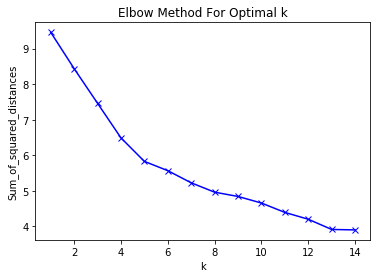

In [20]:
Seattle_grouped_clustering = Seattle_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Seattle_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is around 5. Let us try grouping neighborhoods into 5 clusters.

In [21]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Seattle_grouped_clustering)
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Now, let's create a new df that includes the cluster as well as the top 10 venues for each neighborhood.

In [22]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Seattle_merged = df_Seattle_lonlat
Seattle_merged = Seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [23]:
Seattle_merged.groupby('Cluster Labels')['Neighborhood'].count()

Cluster Labels
0    65
1     5
2     1
3     1
4     2
Name: Neighborhood, dtype: int64

In [24]:
Seattle_merged.head()

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Broadway,1495,47.625314,-122.324739,0,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio
1,1,Belltown,1935,47.614646,-122.344796,0,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel
2,2,University District,1253,47.663065,-122.314097,0,Thai Restaurant,Bubble Tea Shop,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Café,Movie Theater,Deli / Bodega,Tea Room
3,3,Lower Queen Anne,1669,47.624803,-122.356765,0,Coffee Shop,Performing Arts Venue,Indie Movie Theater,Opera House,Yoga Studio,Café,Japanese Restaurant,Lounge,Bookstore,Mediterranean Restaurant
4,4,First Hill,1581,47.609792,-122.323554,0,Sandwich Place,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bar,Hotel,Asian Restaurant,Ice Cream Shop,Brewery,Food & Drink Shop


Let's visualize the clusters.

In [25]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Seattle_merged['Latitude'], Seattle_merged['Longitude'], Seattle_merged['Neighborhood'], Seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Maps cannot be displayed on Github, so here's a screenshot: ![screenshot](screenshot_2.png)

### Section 5: Add another clustering variable

So far, the clusters based primarily on venues are not well-balanced in that too many neighborhoods belong to the second cluster (Cluster 0). I will experiment with another variable to see if I can clusters more balanced.

#### Proximity to light rail stations

Seattle has a light rail system connecting the University of Washington and Sea-Tac International Airport (as of 2020). Since a lot of people use it for commute, it might be useful to cluster neighborhoods based on their distance from the nearest light rail station.

I have collected geographical information of all the light rail stations, which I will load below.

In [28]:
LR_df = pd.read_csv('LR_df.csv')

As an instance, let's find out the closest light rail station from Broadway neighborhood. I will the `haversine_distance` function from the `mpu` library to calculate the distance between two longitude/latitude points.

In [30]:
BW_lat = Seattle_merged['Latitude'][0]
BW_lon = Seattle_merged['Longitude'][0]

distances = []
for lat, lon in zip(LR_df['Latitude'], LR_df['Longitude']):
    distances.append(mpu.haversine_distance((lat, lon), (BW_lat, BW_lon)))

LR_distances = pd.DataFrame({'Station':LR_df['Station'].values, 'Distance':distances})

LR_closest = LR_distances.loc[LR_distances['Distance'] == min(LR_distances['Distance']), 'Station'].item()

print('The closest station from {} is {}, and it is {} kms away.'.format(Seattle_merged['Neighborhood'][0], 
                                                               LR_closest, 
                                                               round(min(LR_distances['Distance']),2)))

The closest station from Broadway is Capitol Hill, and it is 0.7 kms away.


(16, 2)

Now let's do the same for all the neighborhoods, and merge the results on the `Seattle_merged` dataframe.

In [31]:
dist_to_closest_station = []
for nhood, lat1, lon1 in zip(Seattle_merged['Neighborhood'], Seattle_merged['Latitude'], Seattle_merged['Longitude']):
    distances = []
    for lat2, lon2 in zip(LR_df['Latitude'], LR_df['Longitude']):
        distances.append(mpu.haversine_distance((lat1, lon1), (lat2, lon2)))
        closest = min(distances)
    dist_to_closest_station.append(closest)

In [34]:
Seattle_merged['Distance to closest LR station (in km)'] = dist_to_closest_station
Seattle_grouped_clustering.head()

,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.000000,...,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.057143,...,0.00,0.0,0.000000,0.028571,0.0,0.0,0.0,0.00,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.026316,...,0.00,0.0,0.000000,0.184211,0.0,0.0,0.0,0.00,0.0,0.026316
3,0.000000,0.0,0.0,0.0,0.03,0.000000,0.0,0.0,0.01,0.000000,...,0.01,0.0,0.000000,0.020000,0.0,0.0,0.0,0.01,0.0,0.000000
4,0.034483,0.0,0.0,0.0,0.00,0.034483,0.0,0.0,0.00,0.000000,...,0.00,0.0,0.034483,0.103448,0.0,0.0,0.0,0.00,0.0,0.000000


In [35]:
Seattle_grouped_clustering_LR = Seattle_grouped_clustering 
Seattle_grouped_clustering_LR['Distance to closest LR station (in km)'] = dist_to_closest_station

I used the elbow method again (not shown here) to find out that the elbow falls around 4.

In [36]:
kclusters_LR = 4
kmeans_LR = KMeans(n_clusters=kclusters_LR, random_state=0).fit(Seattle_grouped_clustering_LR)
kmeans_LR.labels_[0:10] #shows the clusters of the first ten neighborhoods 

array([2, 2, 2, 0, 2, 2, 0, 3, 2, 0], dtype=int32)

In [47]:
neighborhoods_venues_sorted_LR = neighborhoods_venues_sorted
neighborhoods_venues_sorted_LR = neighborhoods_venues_sorted_LR.drop('Cluster Labels', 1) #drops the labels from the previous clustering
neighborhoods_venues_sorted_LR.insert(0, 'Cluster Labels', kmeans_LR.labels_)
Seattle_merged_LR = df_Seattle_lonlat
Seattle_merged_LR = Seattle_merged_LR.join(neighborhoods_venues_sorted_LR.set_index('Neighborhood'), on='Neighborhood')
Seattle_merged_LR['Distance to closest LR station (in km)'] = dist_to_closest_station

In [41]:
Seattle_merged_LR.groupby('Cluster Labels')['Neighborhood'].count()

Cluster Labels
0    19
1    22
2    21
3    12
Name: Neighborhood, dtype: int64

In [43]:
map_clusters_LR = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters_LR)
ys = [i + x + (i*x)**2 for i in range(kclusters_LR)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Seattle_merged_LR['Latitude'], Seattle_merged_LR['Longitude'], Seattle_merged_LR['Neighborhood'], Seattle_merged_LR['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_LR)
    
for lat, lng, station in zip(LR_df['Latitude'], LR_df['Longitude'], LR_df['Station']):
    label_st = '{}'.format(station)
    label_st = folium.Popup(label_st, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label_st,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_clusters_LR)
       
map_clusters_LR

Maps cannot be displayed on Github, so here's a screenshot: ![screenshot](screenshot_3.png)

Okay, now the clusters are much more balanced, though I'm not sure if I can observe clear a tendency that certain clusters are close to a light rail station (indicated with a smaller blue dot on the map).

### Section 6: Create a recommendation system interface

Now it's time to create a system that pushes neighborhood recommendations based on the customer's preferences. I created a function displayed below that interacts with the customer and recommends neighborhoods to live in based on the venues they prefer to be close to their place.

In [46]:
Seattle_merged_LR.head()

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of matches
0,0,Broadway,1495,47.625314,-122.324739,3,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio,1
1,1,Belltown,1935,47.614646,-122.344796,0,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel,0
2,2,University District,1253,47.663065,-122.314097,3,Thai Restaurant,Bubble Tea Shop,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Café,Movie Theater,Deli / Bodega,Tea Room,1
3,3,Lower Queen Anne,1669,47.624803,-122.356765,0,Coffee Shop,Performing Arts Venue,Indie Movie Theater,Opera House,Yoga Studio,Café,Japanese Restaurant,Lounge,Bookstore,Mediterranean Restaurant,2
4,4,First Hill,1581,47.609792,-122.323554,0,Sandwich Place,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bar,Hotel,Asian Restaurant,Ice Cream Shop,Brewery,Food & Drink Shop,0


In [48]:
def NhoodRecommendation():
    restaurant_q = input("Hi there! Let me see if there is a neighborhood in Seattle you might like. \nFirst of all, what kind of restaurants do you like? \nPlease type 'Chinese,' 'American,' etc.: " )
    other_q_1 = input("Great! Please tell me a place you want in your neighborhood.: ")
    other_q_2 = input("Please tell me another place you want in your neighborhood.: ")
    other_q_3 = input("Please tell me one more place you want in your neighborhood. \nYou can also say 'Nope' if you don't have preferences : ")
    preferred_venues = [restaurant_q, other_q_1, other_q_2, other_q_3]
    matches = []
    for i in range(len(Seattle_merged_LR)):
        match = 0
        for venue in preferred_venues:
            if venue in str(Seattle_merged_LR.iloc[i, 6:15].values):
                match += 1
        matches.append(match)
    if max(matches) == 0:
        print("Your keywords didn't match any of the neighborhoods. Try again!")
    else:
        Seattle_merged_LR['Number of matches'] = matches
        found_matches = Seattle_merged_LR.loc[Seattle_merged_LR['Number of matches'] == max(Seattle_merged_LR['Number of matches'])]
        if len(found_matches) == 1:
            nhood = found_matches['Neighborhood'].iloc[0]
            rent = found_matches['Average_Rent'].iloc[0]
            dist = found_matches['Distance to closest LR station (in km)'].iloc[0]
            print('''We found a match with your preferences!
            {} neighborhood has the average rent of ${} and 
            {} km away from a light rail station.'''.format(nhood,rent,round(dist, 2)))
            # makes a few other neighborhood recs based on the clustering conducted earlier 
            other_recs = input("Would you like to see other recommendations? Type Y or N: ")
            if other_recs == "N":
                print("Goodbye!")
            elif other_recs == "Y":
                other_matches = Seattle_merged_LR.loc[Seattle_merged_LR['Cluster Labels'] == found_matches['Cluster Labels'].iloc[0]]
                other_matches = other_matches[other_matches['Neighborhood'] != nhood] #removes the neighborhood already recommended
                first = other_matches['Neighborhood'].iloc[0]
                second = other_matches['Neighborhood'].iloc[1]
                third = other_matches['Neighborhood'].iloc[2]
                print("You might also want to check out neighborhoods like {}, {}, and {}!".format(first,second,third))
        elif len(found_matches) > 1:
            lowest_rent = found_matches.loc[found_matches['Average_Rent'] == min(found_matches['Average_Rent']), 'Neighborhood'].item()
            closest_LR = found_matches.loc[found_matches['Distance to closest LR station (in km)'] == min(found_matches['Distance to closest LR station (in km)']), 'Neighborhood'].item()
            print('''We found {} match(es) with your preferences!
            Among them, {} neighborhood has the lowest average rent of ${} and 
            {} is only {} km away from a light rail station.'''.format(len(found_matches), lowest_rent, min(found_matches['Average_Rent']), closest_LR, round(min(found_matches['Distance to closest LR station (in km)']),2)))

In [49]:
NhoodRecommendation()

Hi there! Let me see if there is a neighborhood in Seattle you might like. 
First of all, what kind of restaurants do you like? 
Please type 'Chinese,' 'American,' etc.: Japanese
Great! Please tell me a place you want in your neighborhood.: Theater
Please tell me another place you want in your neighborhood.: Park
Please tell me one more place you want in your neighborhood. 
You can also say 'Nope' if you don't have preferences : Nope
We found a match with your preferences!
            Lower Queen Anne neighborhood has the average rent of $1669 and 
            2.07 km away from a light rail station.
Would you like to see other recommendations? Type Y or N: Y
You might also want to check out neighborhoods like Belltown, First Hill, and Fremont!


### Section 7: Evaluation, discussion, and conclusion

Through this project, I generated datasets concerning different neighborhoods of Seattle and their geographical locations, conducted a clustering of the neighborhoods by means of the k-means clustering method, and constructed a recommendation interface. Admittedly, there are some points of improvements regarding my recommendation systen. First, the system needs refining, as the input from the customer has to be identical to the name of a venue in the dataset in order for them to match at this point. Second, it is worthwhile to keep exploring other variables that determine the clusters. Third, it would be interesting to see whether the code I generated here could be applied to exploring other cities, and how neighborhoods would be clusteded together in different places. I am planning on working towards addressing the points, and hope to create a more refined recommendation system for my future projects.